In [1]:
import netket as nk
import netket.experimental as nkx
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
from scipy.sparse.linalg import eigsh
import numpy as np
import scipy.sparse.linalg
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt
from pathlib import Path

import sys, os
sys.path.append('/Users/wttai/Documents/Jupyter/machine_learning/common_lib')
sys.path.append('/home1/wttai/machine_learning/common_lib')
from networks import *
import h5py
from tenpy.tools import hdf5_io

/home1/wttai/TeNPy/tenpy/tools/optimization.py:317: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [10]:
L = 4
N = 8
m = 3.5
U = 2.0
pbc = True
query_dict_dmrg =  {"L": L, "N": N, "t": 1.0, "U": U, "m": m, "pbc": pbc}
date_dmrg = "20241210_0356"
date_netket = "20241213_04"
BASE_PATH_DMRG = Path(f"/home1/wttai/machine_learning/dmrg_qwz/data/dmrg_qwz_{date_dmrg}")

data_dmrg = []
for root, dirs, files in os.walk(BASE_PATH_DMRG):
    for name in files:
        path = os.path.join(root, name)
        with h5py.File(path, 'r') as f:
            data = hdf5_io.load_from_hdf5(f)
            metadata = data["metadata"]
            matched = True
            for key, value in query_dict_dmrg.items():
                if metadata[key] != value:
                    matched = False
                    break
            if matched:
                print(name)
                data_dmrg.append(data)

/home1/wttai/TeNPy/tenpy/tools/hdf5_io.py:1104: UserWarning: Can't import class FermiHubbardSquare from __main__
  warnings.warn(msg, UserWarning)


nb_log_n_hidden=32_n_hidden_layers=1_n_samples=32768.json
slater_log_n_samples=32768.json
nj_log_n_hidden=32_n_hidden_layers=1_n_samples=32768.json
nj_log_n_hidden=32_n_hidden_layers=2_n_samples=32768.json
nb_log_n_hidden=32_n_hidden_layers=2_n_samples=32768.json
nj_log_n_hidden=128_n_hidden_layers=1_n_samples=32768.json
nb_log_n_hidden=128_n_hidden_layers=1_n_samples=32768.json
nj_log_n_hidden=128_n_hidden_layers=2_n_samples=32768.json
nb_log_n_hidden=128_n_hidden_layers=2_n_samples=32768.json


IndexError: list index out of range

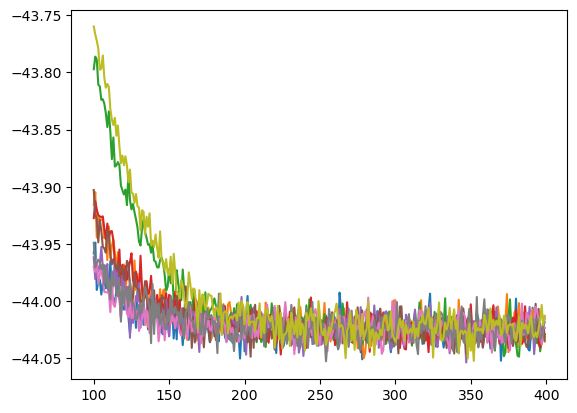

In [11]:
n_samples = 32768
query_dict = {"L": L, "N": N, "t": 1.0, "U": U, "m": m, "pbc": pbc, "n_samples": n_samples}   
#date_netket = "20241128_2048"
BASE_PATH = Path(f"/home1/wttai/machine_learning/netket_qwz/data/netket_qwz_{date_netket}")

data_to_plot = []
for root, dirs, files in os.walk(BASE_PATH):
    for name in files:
        path = os.path.join(root, name)
        data = json.load(open(path))
        metadata = data["metadata"]
        matched = True
        for key, value in query_dict.items():
            if metadata[key] != value:
                matched = False
                break
        if matched:
            print(name)
            data_to_plot.append(data)

for data in data_to_plot:
    plt.plot(data['data']["Energy"]["iters"], data['data']["Energy"]['Mean']['real'], label=f"{data["metadata"]["model"]}, n_hidden = {data["metadata"]["n_hidden"]}, n_hidden_layers = {data["metadata"]["n_hidden_layers"]}")

plt.axhline(y=data_dmrg[0]['data']['E0'], color='r', linestyle='--', label='DMRG') 
title = f"L = {L}, N = {N}, U = {U}, m = {m}, pbc = {query_dict['pbc']}, n_samples = {n_samples}"
plt.title(title)
plt.legend()

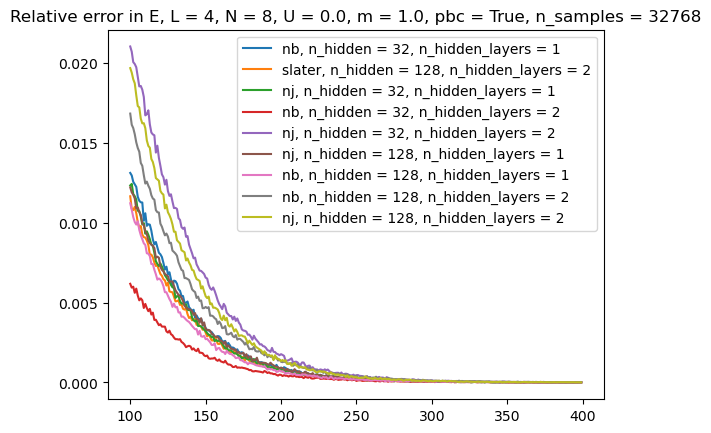

In [ ]:
dmrg_E0 = data_dmrg[0]['data']['E0']
for data in data_to_plot:
    plt.plot(data['data']["Energy"]["iters"], -(data['data']["Energy"]['Mean']['real']-dmrg_E0)/dmrg_E0, label=f"{data["metadata"]["model"]}, n_hidden = {data["metadata"]["n_hidden"]}, n_hidden_layers = {data["metadata"]["n_hidden_layers"]}")

title = f"Relative error in E, L = {L}, N = {N}, U = {U}, m = {m}, pbc = {query_dict['pbc']}, n_samples = {n_samples}"
plt.title(title)
plt.legend()

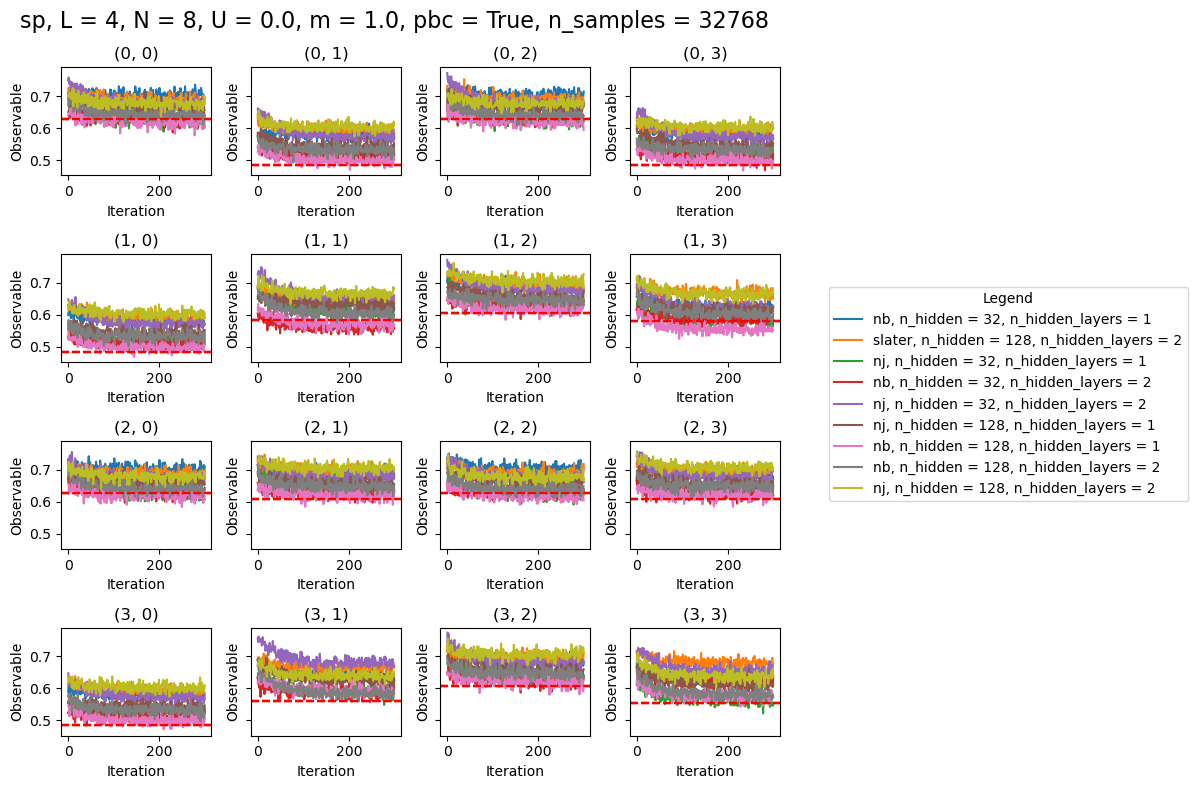

In [8]:
n_corrs = L**2

x_values = np.arange(len(data["data"]['pp'][0]['Mean']['real']))

# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharey=True)

lines = []
labels = []

orbitals_nk, orbitals_dmrg = 'sp', 'ud'

for data in data_to_plot:
    for i in range(n_corrs):
        x = i // L
        y = i % L
        #corr = f"nc{i}nc0"
        line, = axs[x][y].plot(x_values, 
                               data["data"][orbitals_nk][i]['Mean']['real'], 
                               label=f"{data["metadata"]["model"]}, n_hidden = {data["metadata"]["n_hidden"]}, n_hidden_layers = {data["metadata"]["n_hidden_layers"]}")

        corrs_dmrg = (data_dmrg[0]['data']['corrs_results'][orbitals_dmrg])
        # corrs_dmrg = (data_dmrg[0]['data']['corrs_results']['dd']
        #             + data_dmrg[0]['data']['corrs_results']['uu'] 
        #             + 2 * data_dmrg[0]['data']['corrs_results']['ud'])/16
        axs[x][y].axhline(y=corrs_dmrg[x][y], color='r', linestyle='--', label='DMRG') 
        
        axs[x][y].set_title(f"({x}, {y})")
        axs[x][y].set_xlabel('Iteration')
        axs[x][y].set_ylabel('Observable')

        # Collect lines and labels for the legend
        if line.get_label() not in labels:
            lines.append(line)
            labels.append(line.get_label())

title = f"{orbitals_nk}, L = {L}, N = {N}, U = {U}, m = {m}, pbc = {query_dict['pbc']}, n_samples = {n_samples}"
fig.suptitle(title, fontsize=16)

# Add a shared legend to the right of the figure
fig.legend(
    lines, labels, 
    loc='center right', 
    title="Legend", 
    bbox_to_anchor=(1.5, 0.5)
)


# Show the plot
plt.tight_layout()
plt.show()


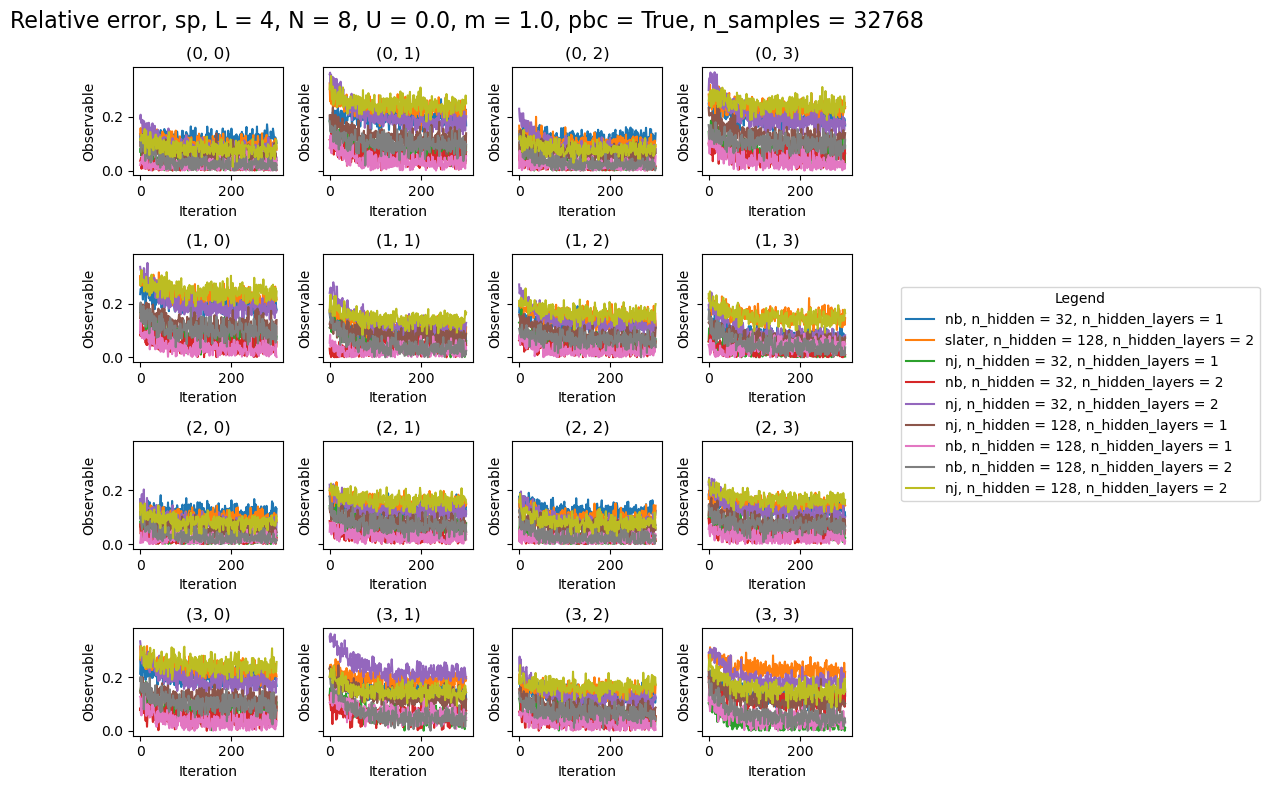

In [ ]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharey=True)

lines = []
labels = []

for data in data_to_plot:
    for i in range(n_corrs):
        x = i // L
        y = i % L
        #corr = f"nc{i}nc0"
        corrs_dmrg = (data_dmrg[0]['data']['corrs_results'][orbitals_dmrg])

        line, = axs[x][y].plot(x_values, 
                               np.abs((data["data"][orbitals_nk][i]['Mean']['real']- corrs_dmrg[x][y])/corrs_dmrg[x][y]), 
                               label=f"{data["metadata"]["model"]}, n_hidden = {data["metadata"]["n_hidden"]}, n_hidden_layers = {data["metadata"]["n_hidden_layers"]}")


        #axs[x][y].axhline(y=corrs_dmrg[x][y], color='r', linestyle='--', label='DMRG') 
        
        axs[x][y].set_title(f"({x}, {y})")
        axs[x][y].set_xlabel('Iteration')
        axs[x][y].set_ylabel('Observable')

        # Collect lines and labels for the legend
        if line.get_label() not in labels:
            lines.append(line)
            labels.append(line.get_label())

title = f"Relative error, {orbitals_nk}, L = {L}, N = {N}, U = {U}, m = {m}, pbc = {query_dict['pbc']}, n_samples = {n_samples}"
fig.suptitle(title, fontsize=16)

# Add a shared legend to the right of the figure
fig.legend(
    lines, labels, 
    loc='center right', 
    title="Legend", 
    bbox_to_anchor=(1.5, 0.5)
)

# Show the plot
plt.tight_layout()
plt.show()